In [107]:
import os
import datetime

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import seaborn as sns

from IPython.display import display

from functools import partial

from utils.multi_processing_functions import *

PLOT_PATH = './plots_grasp_aligned_fixations/'


In [2]:
print(scipy.__version__)

1.5.0


In [3]:
import multiprocessing as mp

def pandas_mp_apply(grouped_df, apply_func):
    with mp.Pool(mp.cpu_count() - 1) as p:
        ret_list = p.map(apply_func, [(group, name) for name, group in grouped_df])
    return pd.concat(ret_list)

In [4]:
sns.set(palette='muted', context='talk', style='ticks')
scpt = sns.color_palette()

In [5]:
samples_df = pd.read_csv(
    '../processed_data/EIH/05_ET_samples_graspInfo.csv',
    parse_dates = ['timestamp_dt'],
    dtype = {
        'isFixV': np.bool, 'grasp_onset_bool': np.bool,'grasp_end_bool': np.bool,
        'subjectID': int, 'trialNum': int, 'trialID': int,
    },
    index_col=False,
)

samples_df = samples_df.rename(columns = {
    'subjectID': 'subject_id',
    'trialNum' : 'trial_num',
    'combinedEye_raycastHitObject' : 'eye_hit',
    'eye_shelfHits' : 'eye_shelf_hit',
    'trialID' : 'trial_id',
    'isFixV' : 'is_fixation',
    'nosePointer_shelfHits' : 'head_hit',
    'isOutlierFix' : 'is_outlier_fixation',
    'handData_graspedObject' : 'grasp'
    
})
print(samples_df.shape)
print(samples_df.query('eye_shelf_hit == "ERROR"').shape)

samples_df = (
    samples_df
    .query('subject_id not in [2011, 2039, 2034, 2042, 2046]')
    .query('eye_shelf_hit != "ERROR"')
    .query('subject_id != 2022 and trial_num != 0')
    .query('subject_id != 2044 and trial_num != 1')
)

samples_df.loc[
    (
        (samples_df.subject_id == 2040)
        & (samples_df.subjectfileName.str.endswith('_2.etd'))
    ), 'trial_num'
] += 3

samples_df['trial_type'] = (
    samples_df
    .trial_id
    .apply(lambda s: 'easy' if s in np.arange(0,8) else 'hard')
)

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (32,70,71) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(10592078, 72)
(61, 72)


In [6]:
samples_df = samples_df[[
    'subject_id', 'trial_num', 'trial_type', 'timestamp_dt', 'is_fixation', 'eye_hit', 'grasp',
    'grasp_onset_bool', 'eye_shelf_hit', 'fix_duration', 'grasp_end_bool', 'grasp_duration', 
    'is_outlier_fixation', 'pickup_location', 'drop_location'
]]

In [7]:
valid_objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow',
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow',
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']

samples_df.loc[~(samples_df.eye_hit.isin(valid_objs)) & 
           ~(pd.isnull(samples_df.eye_hit)),
               'eye_hit'] ='Other'

In [8]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8618620 entries, 8838 to 10592077
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   subject_id           int32         
 1   trial_num            int32         
 2   trial_type           object        
 3   timestamp_dt         datetime64[ns]
 4   is_fixation          bool          
 5   eye_hit              object        
 6   grasp                object        
 7   grasp_onset_bool     bool          
 8   eye_shelf_hit        object        
 9   fix_duration         float64       
 10  grasp_end_bool       bool          
 11  grasp_duration       float64       
 12  is_outlier_fixation  bool          
 13  pickup_location      object        
 14  drop_location        object        
dtypes: bool(4), datetime64[ns](1), float64(2), int32(2), object(6)
memory usage: 756.2+ MB


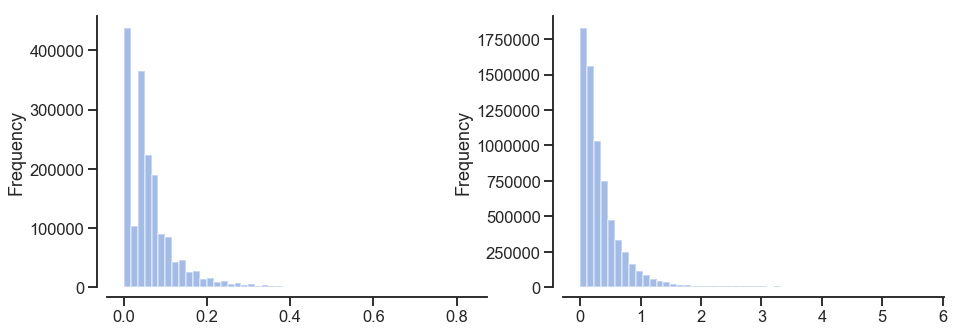

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
samples_df[samples_df.is_fixation == 0].fix_duration.plot.hist(bins=50, alpha=0.5, ax=ax[0])
samples_df[samples_df.is_fixation == 1].fix_duration.plot.hist(bins=50, alpha=0.5, ax=ax[1]);
sns.despine(offset=10)

In [111]:
# in seconds
bin_size = 0.25
offset_start = -4
offset_stop = 4

#number of subjects the mp can handle
# subjects = samples_df.subject_id.unique()[15]

grp_cols = ['subject_id', 'trial_num']
grasp_epochs_df = (
    pandas_mp_apply(
        samples_df
#         .query('subject_id == @subjects')
        .groupby(grp_cols),
        partial(get_epoch_grasp_on, offset_start=offset_start, offset_stop=offset_stop)
    )
)
grasp_epochs_df.head()

timestamp_dt  \
subject_id trial_num trial_type grasp_num                                 
2006       2         hard       0         1970-01-01 00:01:12.080276489   
                                0         1970-01-01 00:01:12.091545105   
                                0         1970-01-01 00:01:12.102241516   
                                0         1970-01-01 00:01:12.113830566   
                                0         1970-01-01 00:01:12.124412537   

                                           is_fixation         eye_hit  \
subject_id trial_num trial_type grasp_num                                
2006       2         hard       0                 True  Tetraeder_Blue   
                                0                 True  Tetraeder_Blue   
                                0                 True  Tetraeder_Blue   
                                0                 True  Tetraeder_Blue   
                                0                 True  Tetraeder_Blue   

                                          eye_shelf_hit target_object_fix  \
subject_id trial_num trial_type grasp_num                                   
2006       2         hard       0                   2_2             False   
                                0                   2_2             False   
                                0                   2_2             False   
                                0                   2_2             False   
                                0                   2_2             False   

                                          target_shelf_fix  \
subject_id trial_num trial_type grasp_num                    
2006       2         hard       0                      NaN   
                                0                      NaN   
                                0                      NaN   
                                0                      NaN   
                                0                      NaN   

                                          non_target_object_fix  \
subject_id trial_num trial_type grasp_num                         
2006       2         hard       0                          True   
                                0                          True   
                                0                          True   
                                0                          True   
                                0                          True   

                                          non_target_shelf_fix  \
subject_id trial_num trial_type grasp_num                        
2006       2         hard       0                          NaN   
                                0                          NaN   
                                0                          NaN   
                                0                          NaN   
                                0                          NaN   

                                          non_target_object_same_color  \
subject_id trial_num trial_type grasp_num                                
2006       2         hard       0                                False   
                                0                                False   
                                0                                False   
                                0                                False   
                                0                                False   

                                          non_target_object_same_shape  \
subject_id trial_num trial_type grasp_num                                
2006       2         hard       0                                 True   
                                0                                 True   
                                0                                 True   
                                0                                 True   
                                0                                 True   

                                              grasp_object  \
subjec

In [112]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']
avg_fixations_df = (
    pandas_mp_apply(
        grasp_epochs_df.groupby(grp_cols),
        get_avg_fixations,
    )
)
avg_fixations_df.head()

target_object_fix_count  \
subject_id trial_num trial_type time_bin                            
2006       2         hard       -3.75                           2   
                                -3.50                          22   
                                -3.25                           3   
                                -3.00                           0   
                                -2.75                          18   

                                          total_object_fix_count  \
subject_id trial_num trial_type time_bin                           
2006       2         hard       -3.75                        227   
                                -3.50                        221   
                                -3.25                        217   
                                -3.00                        208   
                                -2.75                        219   

                                          target_shelf_fix_count  \
subject_id trial_num trial_type time_bin                           
2006       2         hard       -3.75                         26   
                                -3.50                          4   
                                -3.25                          0   
                                -3.00                          0   
                                -2.75                          2   

                                          total_shelf_fix_count  \
subject_id trial_num trial_type time_bin                          
2006       2         hard       -3.75                       227   
                                -3.50                       221   
                                -3.25                       217   
                                -3.00                       208   
                                -2.75                       219   

                                          non_target_object_fix_count  \
subject_id trial_num trial_type time_bin                                
2006       2         hard       -3.75                              34   
                                -3.50                             106   
                                -3.25                             148   
                                -3.00                             139   
                                -2.75                              93   

                                          non_target_object_same_shape_count  \
subject_id trial_num trial_type time_bin                                       
2006       2         hard       -3.75                                     13   
                                -3.50                                      8   
                                -3.25                                     26   
                                -3.00                                     19   
                                -2.75                                     23   

                                          non_target_object_same_color_count  \
subject_id trial_num trial_type time_bin                                       
2006       2         hard       -3.75                                     15   
                                -3.50                                     41   
                                -3.25                                     67   
                                -3.00                                     66   
                                -2.75                                     26   

                                          non_target_shelf_fix_count  \
subject_id trial_num trial_type time_bin                               
2006       2         hard       -3.75                            135   
                                -3.50                             67   
                                -3.25                             43   
                                -3.00                             47   
                                -2.75                             81

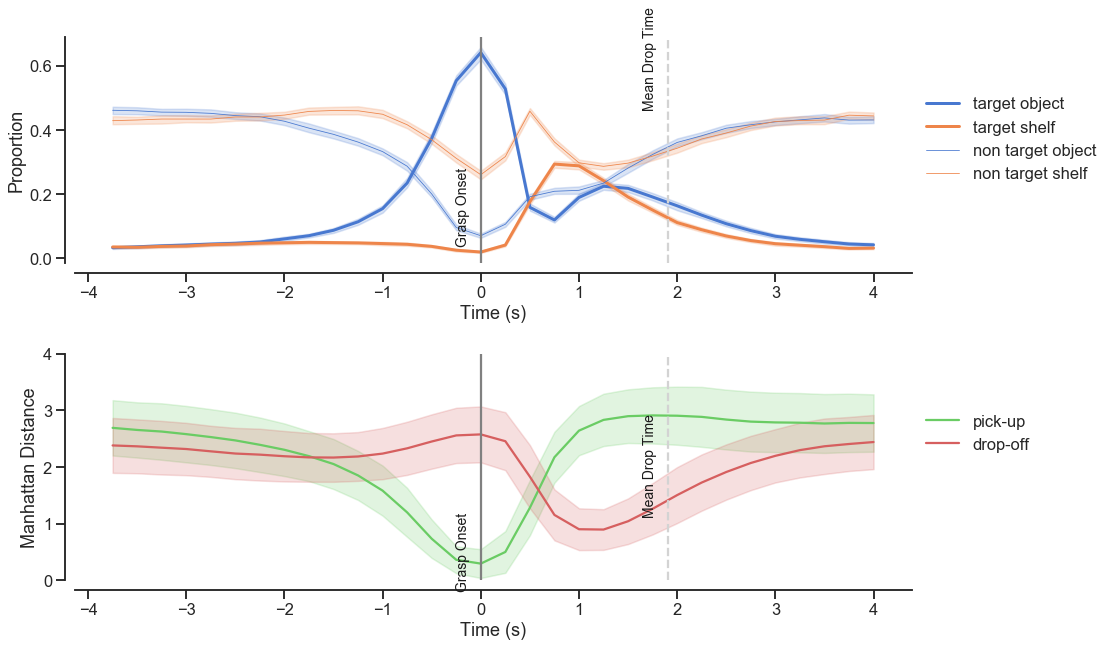

In [114]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax = ax.ravel()
tmpdf = (
    avg_fixations_df
    .reset_index()
)

sns.lineplot(
    tmpdf.time_bin, tmpdf.target_object_fix_prop, 
     lw=3,
#      style=tmpdf.trial_type,
#      legend='brief',
     ax=ax[0],
     label='target object',
     dashes=True,
     color=scpt[0], ci=100,
)
sns.lineplot(
    tmpdf.time_bin, tmpdf.target_shelf_fix_prop,
     lw=3, 
#      style=tmpdf.trial_type,
#      legend=None,
     ax=ax[0],
     label='target shelf',
     color=scpt[1], ci=100 ,
)

sns.lineplot(
    tmpdf.time_bin, tmpdf.non_target_object_fix_prop, 
#      style=tmpdf.trial_type,
     lw=0.8,
#      legend=None,
     ax=ax[0],
     label='non target object', 
     color=scpt[0], ci=100,
)
sns.lineplot(
    tmpdf.time_bin, tmpdf.non_target_shelf_fix_prop, 
#      style=tmpdf.trial_type,
     lw=0.8,
#      legend=None,
     ax=ax[0], 
     label='non target shelf',
     color=scpt[1], ci=100,
)
# sns.lineplot(
#     tmpdf.time_bin, tmpdf.non_target_object_same_feature_fix_prop, 
# #      style=tmpdf.trial_type,
#      lw=2,
# #      legend=None,
#      ax=ax[0],
#      label='non-target same features', 
#      color='k', ci=100,
# )
# sns.lineplot(
#     tmpdf.time_bin, tmpdf.non_target_object_diff_feature_fix_prop, 
# #      style=tmpdf.trial_type,
#      lw=2,
# #      legend=None,
#      ax=ax[0],
#      label='non-target different features', 
#      color='grey', ci=100,
# )

sns.lineplot(
    tmpdf.time_bin, tmpdf.proximity_pick, 
#      legend=None,
#      style=tmpdf.trial_type,
     ax=ax[1],
     label='pick-up', 
     color=scpt[2], ci='sd',
)
sns.lineplot(
    tmpdf.time_bin, tmpdf.proximity_drop, 
#      legend=None,
#      style=tmpdf.trial_type,
     ax=ax[1], 
     label='drop-off', 
     color=scpt[3], ci='sd',
)

ax[0].axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() / np.timedelta64(1, 's'),
    color='lightgrey', ls='--',
)
ax[0].text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() 
    / np.timedelta64(1, 's') - 0.25,
    0.75, 'Mean Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax[0].axvline(0, color='grey', ls='-')
ax[0].text(-0.25,0.25, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)
ax[1].axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() / np.timedelta64(1, 's'),
    color='lightgrey', ls='--',
)
ax[1].text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() 
    / np.timedelta64(1, 's') - 0.25,
    2.75, 'Mean Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax[1].text(-0.25, 1, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)
ax[1].axvline(0, color='grey', ls='-')
ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Time (s)')
# ax[0].set_ylim(0,0.8)
# ax[0].set_xlim(-3,3)
ax[1].set_ylabel('Manhattan Distance')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylim(0,4)
# ax[1].set_xlim(-3,3)
ax[0].legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax[1].legend(frameon=False, bbox_to_anchor=(1, 0.8))
sns.despine(offset=10)
plt.subplots_adjust(hspace=0.4)
plt.savefig(f'{PLOT_PATH}time_course', transparent=True, bbox_inches='tight', quality=90)
del tmpdf

In [79]:
samples_df.loc[~pd.isnull(samples_df.eye_hit)].eye_shelf_hit.value_counts()

Other               859766
Cylinder_Green        2782
Cube_Yellow           2276
Cylinder_Blue         2242
Cube_Red              2102
Tetraeder_Red         2071
Cylinder_Red          2056
Tetraeder_Green       2050
Tetraeder_Blue        2027
Cube_Green            1874
Cube_Blue             1841
Tetraeder_Yellow      1795
Cylinder_Yellow       1587
Sphere_Blue           1465
Sphere_Green          1452
Sphere_Yellow         1451
Sphere_Red            1401
Name: eye_hit, dtype: int64

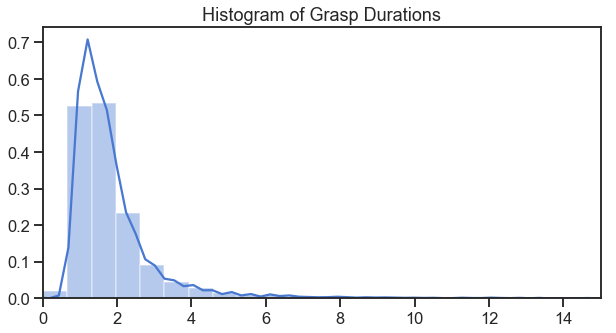

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.distplot(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).values / np.timedelta64(1, 's'),
    norm_hist=True, ax=ax,
)
ax.set_title('Histogram of Grasp Durations');
ax.set_xlim(0,15)
plt.savefig(f'{PLOT_PATH}grasp_duration', transparent=True, bbox_inches='tight', quality=90)


In [18]:
grp_cols = ['subject_id', 'trial_num']
plan_epochs_df = (
    pandas_mp_apply(
        samples_df
#         .query('subject_id in @subjects')
        .groupby(grp_cols),
        partial(get_epoch_grasp_between,
                offset_start=0, offset_stop=0
               )
    )
)
plan_epochs_df.head()

hit_counts
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object eye_hit                    
2006       2         hard       0         Tetraeder_Green      Cylinder_Green    Cylinder_Green          151
                                                                                 Cylinder_Red             24
                                                                                 Other                   116
                                                                                 Tetraeder_Green         114
                                1         Cylinder_Green       Sphere_Green      Cylinder_Blue             3

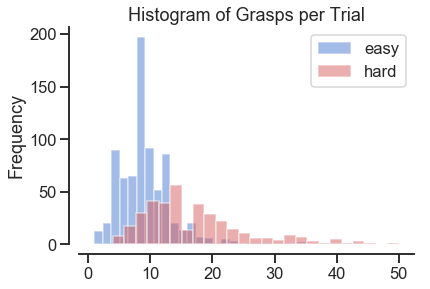

In [28]:
ax = (
    plan_epochs_df
    .reset_index()
    .query('trial_type == "easy"')
    .groupby(['subject_id', 'trial_num', 'trial_type'])
    .grasp_num.max()
    .pipe(lambda s: s[s <= 50])
    .plot.hist(bins=25, alpha=0.5, label='easy')
)
ax = (
    plan_epochs_df
    .reset_index()
    .query('trial_type == "hard"')
    .groupby(['subject_id', 'trial_num', 'trial_type'])
    .grasp_num.max()
    .pipe(lambda s: s[s <= 50])
    .plot.hist(bins=25, alpha=0.5, ax=ax, label='hard', color='r')
)
ax.legend()
# ax.set_xlim(0,50)
plt.title('Histogram of Grasps per Trial');
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}grasps_per_trial', transparent=True, bbox_inches='tight', quality=90)


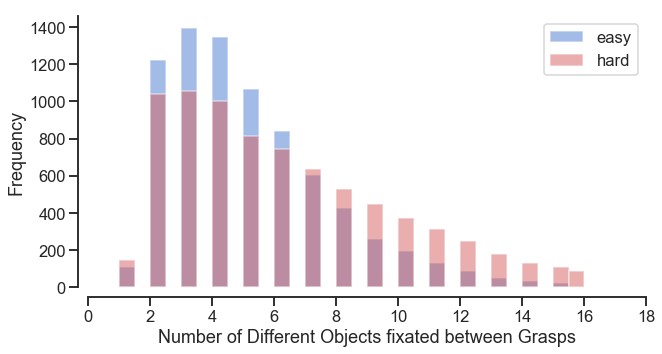

In [20]:
grp_cols = ['subject_id', 'trial_num', 'trial_type', 'grasp_num']
fig, ax = plt.subplots(figsize=(10, 5))
(
    plan_epochs_df
    .query('trial_type == "easy"')
    .reset_index('eye_hit')
    .query('eye_hit != "Other"')
    .groupby(grp_cols)
    .size()
    .plot(kind='hist', alpha=0.5,bins=30, label='easy')
)
(
    plan_epochs_df
    .query('trial_type == "hard"')
    .reset_index('eye_hit')
    .query('eye_hit != "Other"')
    .groupby(grp_cols)
    .size()
    .plot(kind='hist', alpha=0.5,bins=30, color='r', label='hard')
)
plt.xlabel('Number of Different Objects fixated between Grasps')
# plt.title('Histogram of Fixated Object Count between Grasps');
sns.despine(offset=10)
ax.set_xlim(0,18)
ax.legend()
plt.savefig(f'{PLOT_PATH}fixations_between_grasps', transparent=True, bbox_inches='tight', quality=90)


Most epochs between two grasps have fixations on 2-4 different objects, which means most often the subject is thinking about 2-4 different objects (or next moves) between two grasps. Very rarely do the subjects look around at more than 10 objects between grasps.  


The next thing to explore here is to discover the source of the mixture of poisson and this distribution across different cross sections.

In [21]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']
lookahead_grasps_df = (
    pandas_mp_apply(
        (
            plan_epochs_df
#             .reset_index()
#             .loc[pd.IndexSlice[2007, :, :, :, :, :]]
            .groupby(grp_cols)
        ),
        get_lookahead_grasps
    )
)
lookahead_grasps_df.head()

eye_hit  \
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object                   
2006       2         hard       8         Cube_Yellow          Cylinder_Blue           Cube_Blue   
                                                               Cylinder_Blue            Cube_Red   
                                                               Cylinder_Blue         Cube_Yellow   
                                                               Cylinder_Blue       Cylinder_Blue   
                                                               Cylinder_Blue      Cylinder_Green   

                                                                                  hit_counts  \
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object               
2006       2         hard       8         Cube_Yellow          Cylinder_Blue               3   
                                                               Cylinder_Blue               1   
                                                               Cylinder_Blue             211   
                                                               Cylinder_Blue              95   
                                                               Cylinder_Blue              46   

                                                                                  lookahead_grasp_num  \
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object                        
2006       2         hard       8         Cube_Yellow          Cylinder_Blue                      NaN   
                                                               Cylinder_Blue                      NaN   
                                                               Cylinder_Blue                      NaN   
                                                               Cylinder_Blue                      NaN   
                                                               Cylinder_Blue                      NaN   

                                                                                  lookahead_distance  
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object                      
2006       2         hard       8         Cube_Yellow          Cylinder_Blue                     NaN  
                                                               Cylinder_Blue                     NaN  
                                                               Cylinder_Blue                     NaN  
                                                               Cylinder_Blue                     NaN  
                                                               Cylinder_Blue                     NaN

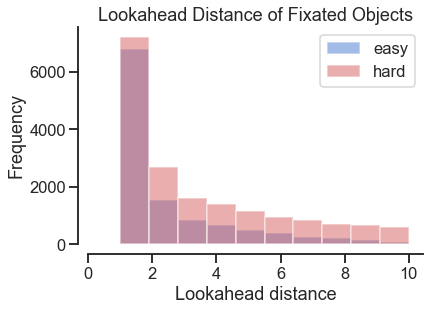

In [22]:
ax = (
    lookahead_grasps_df
    .query('trial_type == "easy"')
    .lookahead_distance
    .pipe(lambda s: s[s <= 10])
    .plot.hist(alpha=0.5, bins=10, label='easy')
)
(
    lookahead_grasps_df
    .query('trial_type == "hard"')
    .lookahead_distance
    .pipe(lambda s: s[s <= 10])
    .plot.hist(alpha=0.5, bins=10, color='r', ax=ax, label='hard')
)
# ax.set_xlim(0,20)
ax.set_xticks(np.arange(0, 11, 2));
ax.set_xlabel('Lookahead distance')
plt.title('Lookahead Distance of Fixated Objects')
ax.legend()
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}lookahead_distance', transparent=True, bbox_inches='tight', quality=90)


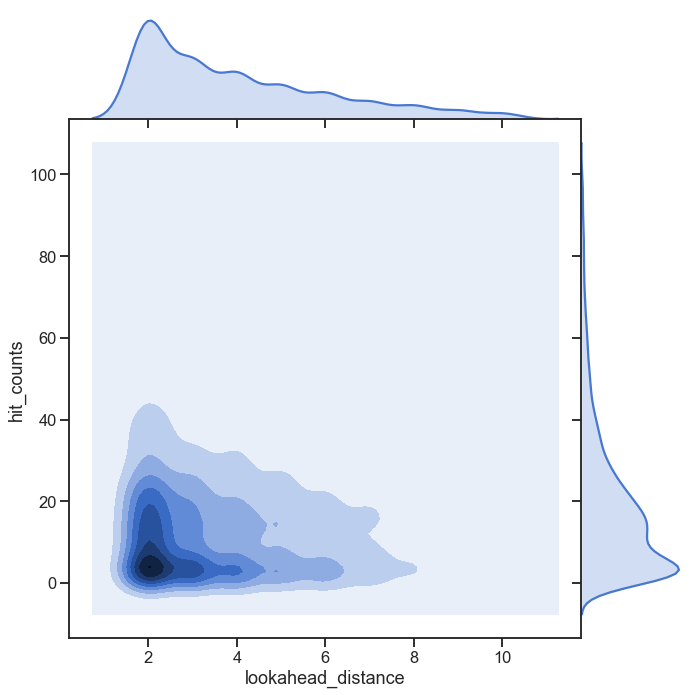

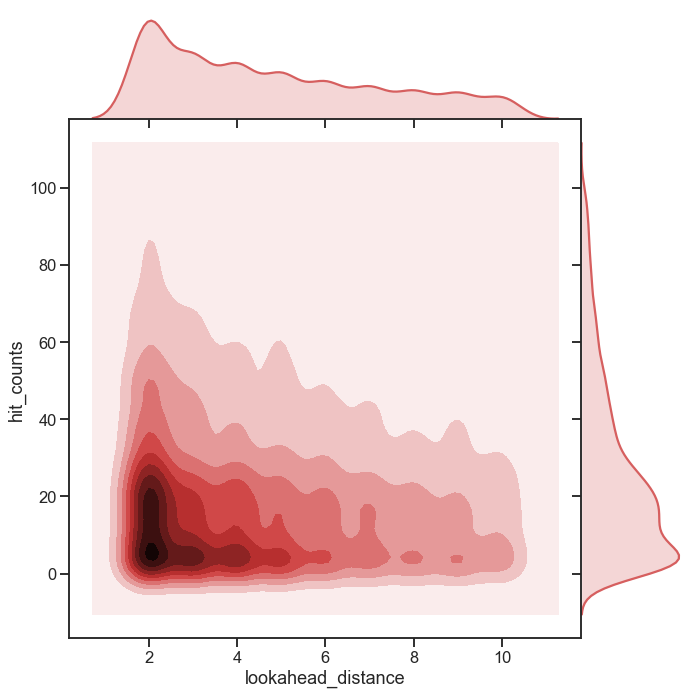

In [23]:
tmpdf = lookahead_grasps_df.query('lookahead_distance <=10 and lookahead_distance > 1 and hit_counts <= 100 and trial_type == "easy"')
sns.jointplot(
    x='lookahead_distance', y='hit_counts', 
    kind='kde',
    data=tmpdf, 
    space=0,
    height=10,
)
tmpdf = lookahead_grasps_df.query('lookahead_distance <=10 and lookahead_distance > 1 and hit_counts <= 100 and trial_type == "hard"')
sns.jointplot(
    x='lookahead_distance', y='hit_counts', 
    kind='kde',
    data=tmpdf, 
    space=0,
    height=10,
    color='r',
)
# sns.despine()

In [24]:
grp_cols = ['subject_id', 'trial_num', 'trial_type', 'grasp_num', 'current_grasp_object']
most_fixated_df = (
    plan_epochs_df
    .groupby(grp_cols)
    .apply(get_most_fixated)
    .to_frame('most_fixated')
    .groupby(['subject_id', 'trial_num', 'trial_type',])
    .apply(get_grasp_distance)
)
most_fixated_df.head()

most_fixated  \
subject_id trial_num trial_type grasp_num current_grasp_object                   
2006       2         hard       0         Tetraeder_Green       Cylinder_Green   
                                1         Cylinder_Green          Sphere_Green   
                                2         Sphere_Green             Sphere_Blue   
                                3         Sphere_Blue           Tetraeder_Blue   
                                4         Tetraeder_Blue          Cylinder_Red   

                                                                grasp_distance  
subject_id trial_num trial_type grasp_num current_grasp_object                  
2006       2         hard       0         Tetraeder_Green                  1.0  
                                1         Cylinder_Green                   1.0  
                                2         Sphere_Green                     1.0  
                                3         Sphere_Blue                      1.0  
                                4         Tetraeder_Blue                   1.0

In [25]:
most_fixated_df.shape

(15652, 2)

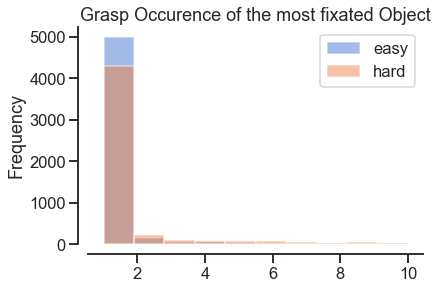

In [26]:
ax = (
    most_fixated_df
    .query('grasp_distance<=10 and trial_type == "easy"')
    .grasp_distance
    .plot(kind='hist', alpha=0.5, bins=10, label='easy')
)
(
    most_fixated_df
    .query('grasp_distance<=10 and trial_type == "hard"')
    .grasp_distance
    .plot(kind='hist', alpha=0.5, bins=10, label='hard', ax=ax)
)

plt.title('Grasp Occurence of the most fixated Object');
sns.despine(offset=10)
ax.legend()
plt.savefig(f'{PLOT_PATH}lookahead_distance_most_fixated', transparent=True, bbox_inches='tight', quality=90)
